## Import necessary packages and modules

In [1]:
import tensorflow as tf
from tensorflow import keras
import sys
import os
from PIL import Image
from glob import glob
import math
import numpy as np
import random
import matplotlib.pyplot as plt

## Define GAN class

In [46]:
class GAN():
    def __init__(self, filedir, noise_dim=256):
        self.img_rows = 128
        self.img_cols = 128
        self.img_channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.img_channels)
        self.filedir = filedir
        self.noise_dim = noise_dim
        
        opt = keras.optimizers.Adam(lr=0.0002, beta_1=0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

        # Build and compile the generator
        self.generator = self.build_generator()
        self.generator.compile(loss='binary_crossentropy', optimizer=opt)

        #######################
        # BUILD THE GAN MODEL #
        #######################
        
        # For the GAN model we will only train the generator
        self.discriminator.trainable = False

        # The generator takes noise as input and generates images
        z = keras.layers.Input(shape=(noise_dim,))
        generator_output = self.generator(z)

        # The discriminator takes generated images as input and determines whether they are real or fake
        discriminator_output = self.discriminator(generator_output)

        # The combined model  (stacked generator and discriminator) takes
        # noise as input => generates images => determines validity 
        gan = keras.Model(z, discriminator_output)
        gan.compile(loss='binary_crossentropy', optimizer=opt)
        self.gan = gan

    def build_generator(self):        
        z = keras.layers.Input(shape=(self.noise_dim,))
        x = keras.layers.Dense(512, input_dim=self.noise_dim)(z)
        x = keras.layers.LeakyReLU(alpha=0.1)(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.Dense(128 * (self.img_rows // 16) * (self.img_cols // 16))(x)
        x = keras.layers.LeakyReLU(alpha=0.1)(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Reshape((self.img_rows // 16, self.img_cols // 16, 128))(x)

        x = keras.layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2,2), padding='same')(x)
        x = keras.layers.LeakyReLU(alpha=0.1)(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.Conv2DTranspose(32, kernel_size=(5, 5), strides=(2,2), padding='same')(x)
        x = keras.layers.LeakyReLU(alpha=0.1)(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.Conv2DTranspose(16, kernel_size=(5, 5), strides=(2,2), padding='same')(x)
        x = keras.layers.LeakyReLU(alpha=0.1)(x)
        x = keras.layers.BatchNormalization()(x)
        
        gen_output = keras.layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2,2), padding='same', activation='sigmoid')(x)
        gen = keras.Model(z, gen_output, name='Generator')
        return gen
        
    def build_discriminator(self):        
        im = keras.layers.Input(shape=self.img_shape)
        x = keras.layers.Conv2D(16, kernel_size=(5, 5), strides=(2, 2), padding='same', input_shape=self.img_shape)(im)
        x = keras.layers.LeakyReLU(alpha=0.1)(x)
        x = keras.layers.Dropout(0.2)(x)

        x = keras.layers.Conv2D(32, kernel_size=(5, 5), strides=(2, 2), padding='same')(x)
        x = keras.layers.LeakyReLU(alpha=0.1)(x)
        x = keras.layers.Dropout(0.2)(x)

        x = keras.layers.Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same')(x)
        x = keras.layers.LeakyReLU(alpha=0.1)(x)
        x = keras.layers.Dropout(0.2)(x)
    
        x = keras.layers.Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same')(x)
        x = keras.layers.LeakyReLU(alpha=0.1)(x)
        x = keras.layers.Dropout(0.2)(x)

        x = keras.layers.Flatten()(x)
        x = keras.layers.Dense(self.noise_dim)(x)
        x = keras.layers.LeakyReLU(alpha=0.1)(x)

        disc_output = keras.layers.Dense(1, activation='sigmoid')(x)
        disc = keras.Model(im, disc_output, name='Discriminator')       
        return disc

    def load_celeba(self, n_images=20_480, mode='RGB'):
        print('Loading dataset...')
        X = []
        files = os.listdir(self.filedir)
        if n_images > 0:
            files = files[:n_images]
        
        for i, f in enumerate(files):
            im = Image.open(os.path.join(self.filedir, f))
            im = im.resize([self.img_rows, self.img_cols])
            im = np.array(im.convert(mode)).astype('float32')
            im = im / 255.0
            im = im[np.newaxis, :]
            X.append(im)
            if i % 500 == 0:
                print('Loaded', i, 'images')
        X = np.concatenate(X, axis=0)
        print('Loaded celebA...')
        return X

    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.noise_dim))
        gen_imgs = self.generator.predict(noise)

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,:])
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig(str(epoch)+".png")
        plt.close()

        
    def train(self, epochs, batch_size=128, save_interval=50):        
        dataset = self.load_celeba()
        half_batch = int(batch_size / 2)
        
        #Create lists for logging the losses
        d_loss_logs_r = []
        d_loss_logs_f = []
        g_loss_logs = []
        n_iterations = dataset.shape[0] // half_batch
        
        for epoch in range(epochs):
            for ite in range(n_iterations):
                ###########################
                # Train the DISCRIMINATOR #
                ###########################
                
                # Get a half batch from real images
                X_real = dataset[ite*half_batch : (ite+1)*half_batch]

                # Get half batch of fake images
                noise = np.random.randn(half_batch, self.noise_dim)
                X_fake = self.generator.predict(noise)

                # Evaluate discriminator loss and update weights
                d_loss_real = self.discriminator.train_on_batch(X_real, np.ones((half_batch, 1)))
                d_loss_fake = self.discriminator.train_on_batch(X_fake, np.zeros((half_batch, 1)))
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

                #######################
                # Train the GENERATOR #
                #######################

                # Get a batch of fake images
                noise = np.random.randn(batch_size, self.noise_dim)

                # Train GAN (discriminator part fixed)
                g_loss = self.gan.train_on_batch(noise, np.ones((batch_size, 1)))

                # Print loss values
                print ("%d %d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch,ite, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples and the generator modl
            if epoch % save_interval == 0:
                self.save_imgs(epoch)
                model_json = self.generator.to_json()
                with open("model"+str(epoch)+".json", "w") as json_file:
                    json_file.write(model_json)
                    
                # serialize weights to HDF5
                self.generator.save_weights("model"+str(epoch)+".h5")
                print("Saved model to disk")

## Train a GAN to generate face images

In [47]:
gan = GAN(filedir='.\\img_align_celeba', noise_dim=512)
gan.discriminator.summary()
gan.generator.summary()

Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 64, 64, 16)        1216      
_________________________________________________________________
leaky_re_lu_50 (LeakyReLU)   (None, 64, 64, 16)        0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 32, 32, 32)        12832     
_________________________________________________________________
leaky_re_lu_51 (LeakyReLU)   (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 32, 32, 32)      

In [48]:
gan.train(epochs=100, batch_size=256, save_interval=10)

.242437, acc.: 90.62%] [G loss: 2.697890]
97 138 [D loss: 0.301349, acc.: 88.28%] [G loss: 2.729089]
97 139 [D loss: 0.304293, acc.: 86.33%] [G loss: 2.750165]
97 140 [D loss: 0.287015, acc.: 89.06%] [G loss: 2.769112]
97 141 [D loss: 0.240388, acc.: 89.06%] [G loss: 2.863772]
97 142 [D loss: 0.277274, acc.: 87.11%] [G loss: 2.720526]
97 143 [D loss: 0.251173, acc.: 88.28%] [G loss: 2.678199]
97 144 [D loss: 0.281031, acc.: 89.84%] [G loss: 2.769764]
97 145 [D loss: 0.304388, acc.: 87.89%] [G loss: 2.821556]
97 146 [D loss: 0.214527, acc.: 90.62%] [G loss: 2.887477]
97 147 [D loss: 0.272346, acc.: 89.45%] [G loss: 2.679979]
97 148 [D loss: 0.316518, acc.: 87.50%] [G loss: 2.821619]
97 149 [D loss: 0.261641, acc.: 88.28%] [G loss: 2.835120]
97 150 [D loss: 0.251089, acc.: 91.02%] [G loss: 2.866408]
97 151 [D loss: 0.312405, acc.: 89.45%] [G loss: 2.607845]
97 152 [D loss: 0.329712, acc.: 84.38%] [G loss: 2.539595]
97 153 [D loss: 0.177317, acc.: 93.75%] [G loss: 2.858549]
97 154 [D loss

## Generating random samples from generator

In [50]:
gan.save_imgs(100)
model_json = gan.generator.to_json()
with open("model100.json", "w") as json_file:
    json_file.write(model_json)
model_json = gan.discriminator.to_json()
with open("model_disc100.json", "w") as json_file:
    json_file.write(model_json)
model_json = gan.gan.to_json()
with open("model_combined100.json", "w") as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
gan.generator.save_weights("model100.h5")
gan.discriminator.save_weights("model_disc100.h5")
gan.gan.save_weights("model_combined100.h5")
print("Saved model to disk")

Saved model to disk


## The model seems to have diverged from local minima after 80 epochs

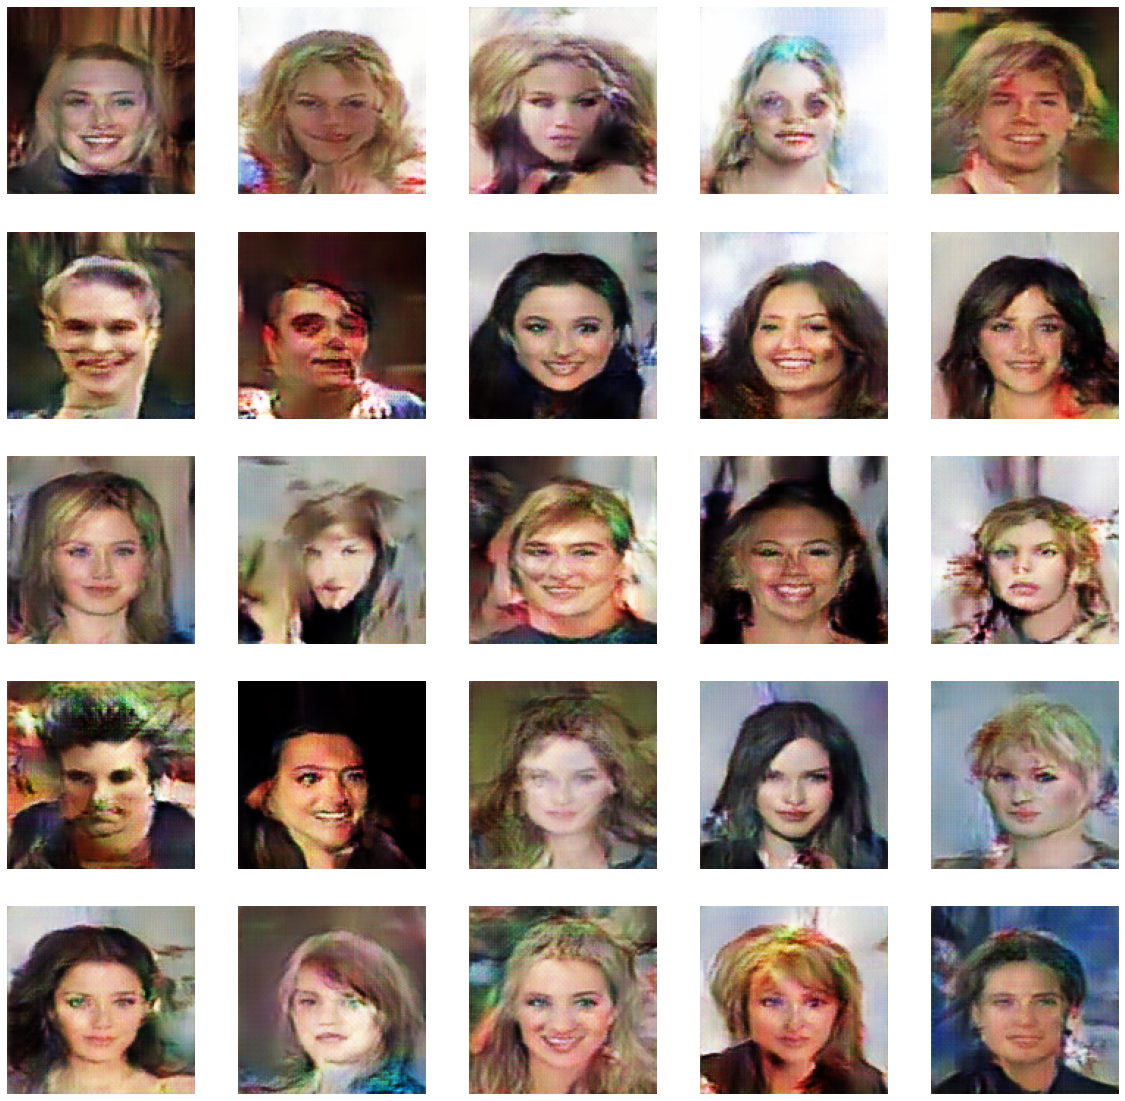

In [78]:
np.random.seed(42)
noise = np.random.randn(64, 512)
gen_imgs = gan.generator.predict(noise)
gen_imgs *= 255.0
gen_imgs = gen_imgs.astype('uint8')
plt.figure(figsize=(20, 20))
n = 5
for i in range(n):
    for j in range(n):
        plt.subplot(n, n, i*n + j + 1)
        plt.imshow(gen_imgs[n*i + j])
        plt.axis('off')

## Using model saved during 80th epoch to generate faces (The last 2 images in the second-last row and the first 3 images in the last row look pretty realistic)

Loaded model from disk


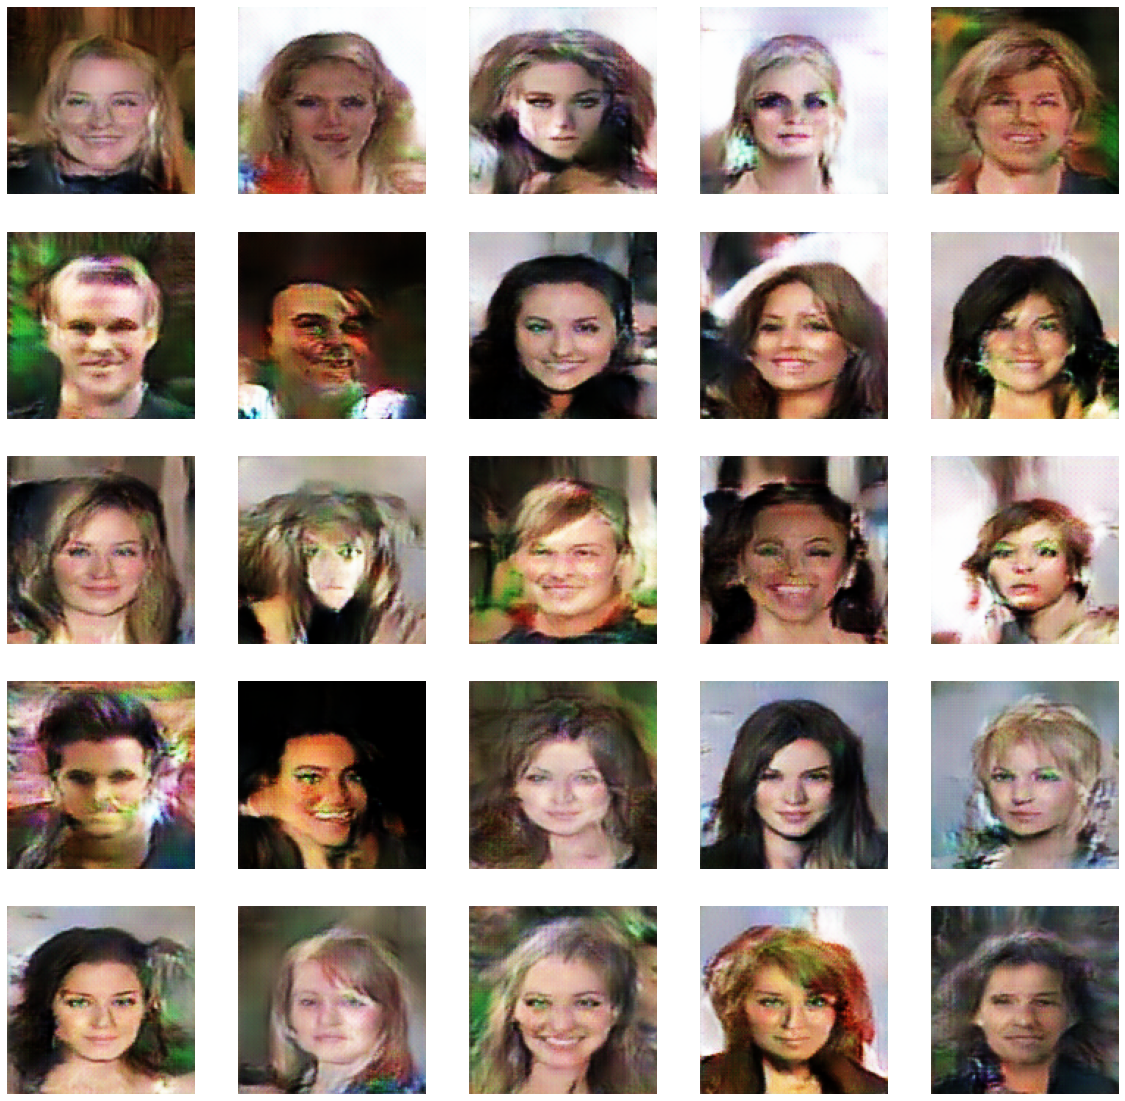

In [77]:
model_weights = 'model80.h5'
model_json = 'model80.json'

# load json and create model
json_file = open(model_json, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = keras.models.model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(model_weights)
print("Loaded model from disk")

np.random.seed(42)
noise = np.random.randn(100, 512)
gen_imgs = loaded_model.predict(noise)
gen_imgs *= 255.0
gen_imgs = gen_imgs.astype('uint8')
plt.figure(figsize=(20, 20))
n = 5
for i in range(n):
    for j in range(n):
        plt.subplot(n, n, i*n + j + 1)
        plt.imshow(gen_imgs[n*i + j])
        plt.axis('off')